In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Pacific_Extent = pd.read_excel(filepath, sheet_name='Pacific-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Pacific_Extent)
fp.date_time(Pacific_Extent)

,Extent,Date
0,668714.275,1979-01-01
1,566930.458,1979-02-01
2,688420.115,1979-03-01
3,859963.043,1979-04-01
4,1127120.160,1979-05-01
...,...,...
533,1134056.102,2023-06-01
534,1484824.377,2023-07-01
535,1671324.717,2023-08-01
536,1726376.097,2023-09-01


In [5]:
scaler = MinMaxScaler()
Pacific_Extent['Extent'] = scaler.fit_transform(Pacific_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 7
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Pacific_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((520, 12, 1), (520,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Pacific_model_LT7/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 34s 444ms/step - loss: 0.2202 - root_mean_squared_error: 0.4693 - val_loss: 0.1541 - val_root_mean_squared_error: 0.3926
Epoch 2/50
53/53 [==============================] - 22s 424ms/step - loss: 0.0749 - root_mean_squared_error: 0.2736 - val_loss: 0.0527 - val_root_mean_squared_error: 0.2296
Epoch 3/50
53/53 [==============================] - 21s 412ms/step - loss: 0.0518 - root_mean_squared_error: 0.2276 - val_loss: 0.0484 - val_root_mean_squared_error: 0.2200
Epoch 4/50
53/53 [==============================] - 22s 429ms/step - loss: 0.0470 - root_mean_squared_error: 0.2169 - val_loss: 0.0424 - val_root_mean_squared_error: 0.2059
Epoch 5/50
53/53 [==============================] - 23s 433ms/step - loss: 0.0384 - root_mean_squared_error: 0.1960 - val_loss: 0.0315 - val_root_mean_squared_error: 0.1776
Epoch 6/50
53/53 [==============================] - 23s 441ms/step - loss: 0.0287 - root_mean_squared_error: 0.1695 - val_loss: 0.0191 

53/53 [==============================] - 3s 52ms/step - loss: 0.0061 - root_mean_squared_error: 0.0780 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0665
Epoch 32/50
53/53 [==============================] - 3s 51ms/step - loss: 0.0065 - root_mean_squared_error: 0.0809 - val_loss: 0.0050 - val_root_mean_squared_error: 0.0708
Epoch 33/50
53/53 [==============================] - 3s 52ms/step - loss: 0.0064 - root_mean_squared_error: 0.0800 - val_loss: 0.0054 - val_root_mean_squared_error: 0.0736
Epoch 34/50
53/53 [==============================] - 3s 58ms/step - loss: 0.0058 - root_mean_squared_error: 0.0761 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0700
Epoch 35/50
53/53 [==============================] - 24s 460ms/step - loss: 0.0060 - root_mean_squared_error: 0.0777 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0622
Epoch 36/50
53/53 [==============================] - 24s 460ms/step - loss: 0.0060 - root_mean_squared_error: 0.0777 - val_loss: 0.0038 - val_root_mea

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

10.10579260190328 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

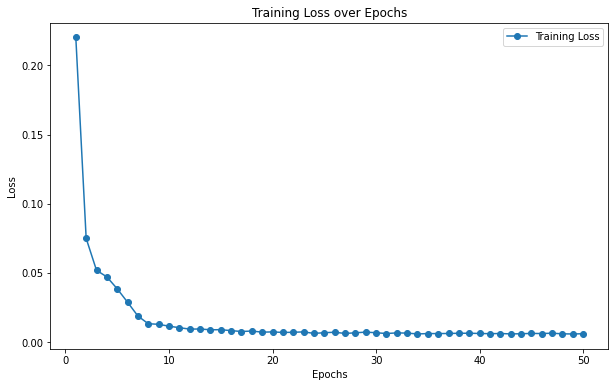

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

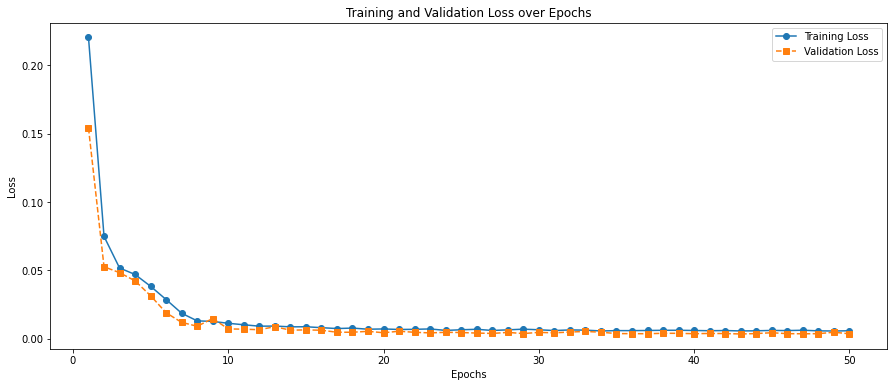

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Pacific_model_LT7/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 14ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.06555966634163106
MAE : 0.05011782231376355


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,1.418189e+06,1264318.504
1,8.959966e+05,863206.294
2,4.654223e+05,635624.004
3,3.749858e+05,460009.672
4,5.372487e+05,610848.036
5,8.170634e+05,819257.445
6,1.156602e+06,1129627.707
7,1.447938e+06,1463383.236
8,1.687284e+06,1614536.727
9,1.867528e+06,1862498.612


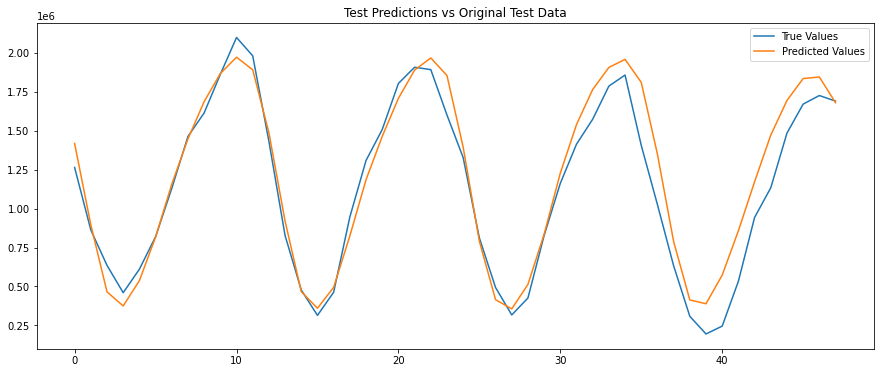

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 22ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

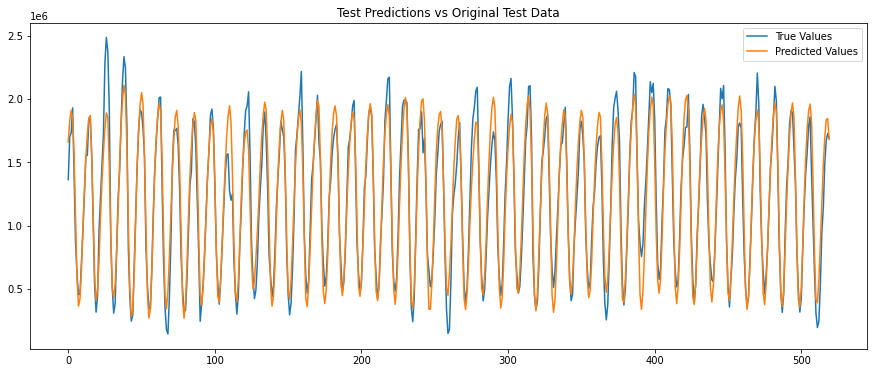

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()